### Import Modules & Initial Settings

In [2]:
import os
import sys
import argparse
import csv
import pandas as pd
import datetime as dt
import numpy as np
from pprint import pprint
from tqdm import tqdm
from pytictoc import TicToc
import traceback
from statistics import median
from statistics import mode
from statistics import mean
from statistics import stdev
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from scipy import signal
import portion as P
import math
from sklearn.neighbors import KernelDensity

# ******************************* User Settings *******************************
class Payload:
    LENGTH = 250              # (Bytes)
    TAG = "000425d401df5e76"  # 2 71828 3 1415926 (hex)            : 8-bytes
    OFS_TIME = (16, 24)       # epoch time of 'yyyy/mm/dd hh:mm:ss': 4-bytes
    OFS_USEC = (24, 32)       # microsecond (usec)                 : 4-bytes
    OFS_SEQN = (32, 40)       # sequence number (start from 1)     : 4-bytes
class ServerIP:
    PUBLIC = "140.112.20.183"  # 2F    
    PRIVATE = "192.168.1.251"  # 2F
    # PUBLIC = "140.112.17.209"  # 3F
    # PRIVATE = "192.168.1.108"  # 3F

database = "/home/wmnlab/D/database/"
date = "2022-11-29"
db_path = os.path.join(database, date, "tsync")
print(db_path)

devices = sorted([
    "sm05", 
    "sm06",
    "sm07",
    "sm08",
    "qc00",
    "qc01",
])

DATA_RATE = 1000e3  # bits-per-second
PKT_RATE = DATA_RATE / Payload.LENGTH / 8  # packets-per-second
print("packet_rate (pps):", PKT_RATE)
# *****************************************************************************

/home/wmnlab/D/database/2022-11-29/tsync
packet_rate (pps): 500.0


### Pcap to Csv

In [5]:
for dev in devices:
    os.system("python3 udp_pcap_to_csv.py -D {}".format(os.path.join(db_path, dev)))

['server_pcap_BL_qc00_3270_2022-11-29_15-48-25_tsync.pcap',
 'server_pcap_BL_qc00_3270_2022-11-29_15-48-25_tsync.csv',
 'client_pcap_BL_qc00_3270_2022-11-29_15-51-04_tsync.pcap',
 'client_pcap_BL_qc00_3270_2022-11-29_15-51-04_tsync.csv']
>>>>> convert from '/home/wmnlab/D/database/2022-11-29/tsync/qc00/server_pcap_BL_qc00_3270_2022-11-29_15-48-25_tsync.pcap' into '/home/wmnlab/D/database/2022-11-29/tsync/qc00/server_pcap_BL_qc00_3270_2022-11-29_15-48-25_tsync.csv'...
>>>>> convert from '/home/wmnlab/D/database/2022-11-29/tsync/qc00/client_pcap_BL_qc00_3270_2022-11-29_15-51-04_tsync.pcap' into '/home/wmnlab/D/database/2022-11-29/tsync/qc00/client_pcap_BL_qc00_3270_2022-11-29_15-51-04_tsync.csv'...

**************************************************
No error occurs!!
**************************************************
Elapsed time is 2.004316 seconds.
['client_pcap_BL_qc01_3272_2022-11-29_15-51-04_tsync.pcap',
 'server_pcap_BL_qc01_3272_2022-11-29_15-48-25_tsync.pcap',
 'server_pcap_BL_qc

In [4]:
def t_mean(timedeltas):
    """
    Average of a list of timedelta.
    """
    return sum(timedeltas, dt.timedelta(0)) / len(timedeltas) if len(timedeltas) else 0

def t_stdev(timedeltas):
    n = len(timedeltas)
    mean = t_mean(timedeltas)
    dev = [x - mean for x in timedeltas]
    dev2 = [x*x for x in dev]
    return math.sqrt(sum(dev2) / n)

def truncate(txdf, rxdf):
    """
    Truncate the rows of lost packets.
    """
    tx_arr = list(zip(txdf['sequence.number'].array, txdf['Timestamp'].array, txdf['Timestamp_epoch'].array))
    rx_arr = list(zip(rxdf['sequence.number'].array, rxdf['Timestamp'].array, rxdf['Timestamp_epoch'].array))
    _tx_arr = []
    j = 0
    N = len(rx_arr)
    for i in range(len(tx_arr)):
        if tx_arr[i][0] == rx_arr[j][0]:
            _tx_arr.append(tx_arr[i])
            if j < N-1:
                j += 1
    ### Since the transmission is stopped by client,
    ### the ending sequence of Downlink-Tx/Uplink-Rx (Server-Side) is larger than Downlink-Rx/Uplink-Tx (Client-Side).
    M = min(len(_tx_arr), len(rx_arr))
    return _tx_arr[:M], rx_arr[:M]

def calc_delta(txdl_df, rxdl_df, txul_df, rxul_df):
    """
    Calculate the time delta between server and client.
        If the client is behind server, delta > 0
        If the client is ahead of server, delta < 0
        server clock := client clock + delta
        
    Returns:
        delta (datetime.timedelta)
        delta (float)
    """
    ### Since the transmission is launched by client, the starting time of Uplink is ahead of Downlink.
    seq_diff = round(500e-3 * PKT_RATE)
    txul_df = txul_df[txul_df['sequence.number'] > seq_diff].reset_index(drop=True)
    rxul_df = rxul_df[rxul_df['sequence.number'] > seq_diff].reset_index(drop=True)
    
    txdl_arr, rxdl_arr = truncate(txdl_df, rxdl_df)
    txul_arr, rxul_arr = truncate(txul_df, rxul_df)

    M = min(len(txdl_arr), len(txul_arr))
    txdl_arr, rxdl_arr, txul_arr, rxul_arr = txdl_arr[:M], rxdl_arr[:M], txul_arr[:M], rxul_arr[:M]
    
    timedelta_list = []
    epoch_delta_list = []
    for ts1, ts2, ts3, ts4 in zip(txdl_arr, rxdl_arr, txul_arr, rxul_arr):
        latency_dl = ts2[1] - ts1[1]
        epoch_latency_dl = ts2[2] - ts1[2]
        latency_ul = ts4[1] - ts3[1]
        epoch_latency_ul = ts4[2] - ts3[2]
        timedelta_list.append((latency_ul - latency_dl) / 2)
        epoch_delta_list.append((epoch_latency_ul - epoch_latency_dl) / 2)
    
    # print(type(timedelta_list[0]))              # <class 'pandas._libs.tslibs.timedeltas.Timedelta'> : datetime64[ns]
    # print(type(dt.timedelta(microseconds=10)))  # <class 'datetime.timedelta'> : microseconds

    # print(t_mean(timedelta_list))
    # print(median(timedelta_list))

    timedeltas = [t_mean(timedelta_list), median(timedelta_list)]
    epoch_deltas = [mean(epoch_delta_list), median(epoch_delta_list)]
    timedelta = (max(timedeltas).round('us'), min(timedeltas).round('us'))
    epoch_delta = (round(max(epoch_deltas), 6), round(min(epoch_deltas), 6))
    ### Use mean or median: https://www.scribbr.com/statistics/central-tendency/
    ### Pandas.Timedelta: https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html
    ### Pandas.Timedelta.round: https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.round.html
    # return timedelta, epoch_delta
    return timedelta_list, epoch_delta_list

def del_outliers(num_list):
    _num_list = sorted(num_list)
    # print(_num_list)
    print("Length of list:", len(_num_list))

    upper_q = np.percentile(_num_list, 75)
    lower_q = np.percentile(_num_list, 25)
    iqr = (upper_q - lower_q) * 1.5
    q_set = (lower_q - iqr, upper_q + iqr)
    # print(q_set)

    result_list = []
    ret_list = []
    for i, x in enumerate(_num_list):
        if x >= q_set[0] and x <= q_set[1]:
            result_list.append(x)
            ret_list.append(i)
    # print(result_list)
    print("Length of resulting list:", len(result_list))
    return result_list, ret_list

def del_outliers_2(num_list):
    _num_list = sorted(num_list)

    upper_q = np.percentile(_num_list, 75)
    lower_q = np.percentile(_num_list, 25)
    # iqr = (upper_q - lower_q) * 1.5
    # q_set = (lower_q - iqr, upper_q + iqr)
    q_set = (lower_q, upper_q)

    result_list = []
    ret_list = []
    for i, x in enumerate(_num_list):
        if x >= q_set[0] and x <= q_set[1]:
            result_list.append(x)
            ret_list.append(i)
    return result_list, ret_list

/home/wmnlab/D/database/2022-09-29/_Bandlock_Udp
1
['/home/wmnlab/D/database/2022-09-29/_Bandlock_Udp/sm05/#01']
1
['/home/wmnlab/D/database/2022-09-29/_Bandlock_Udp/sm06/#01']
1
['/home/wmnlab/D/database/2022-09-29/_Bandlock_Udp/sm07/#01']
1
['/home/wmnlab/D/database/2022-09-29/_Bandlock_Udp/sm08/#01']

_Bandlock_Udp
/home/wmnlab/D/database/2022-09-29/_Bandlock_Udp/sm05/#01
Length of list: 28420
Length of resulting list: 24758
[0.022276124920631985,0.038873336907862224]
[147, 366, 590, 827, 908, 973]
[0.01026715459050359, 0.023499791686599318, 0.03703454378488901, 0.05135479488888302, 0.05624905792442528, 0.06017655295294684]
0.008298605993615118


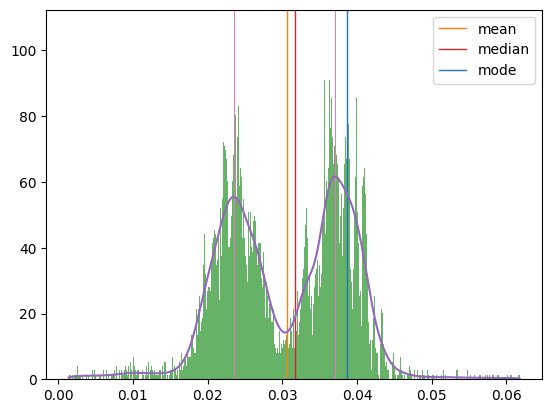

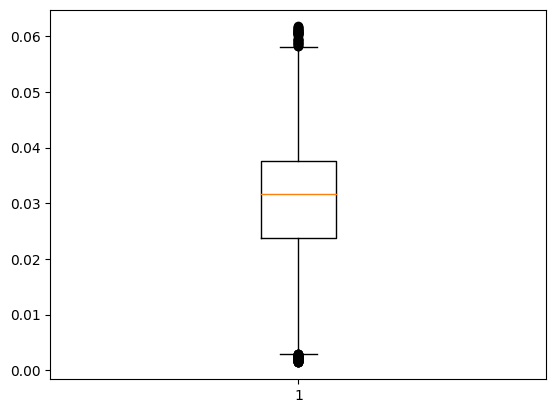

/home/wmnlab/D/database/2022-09-29/_Bandlock_Udp/sm06/#01
Length of list: 27897
Length of resulting list: 22995
[0.24464720428096634,0.2620482934263599]
[151, 360, 606, 806, 971]
[0.232151099511453, 0.24577774228276433, 0.26181675721933173, 0.2748566067612565, 0.28561448263334444]
0.008700544572696782


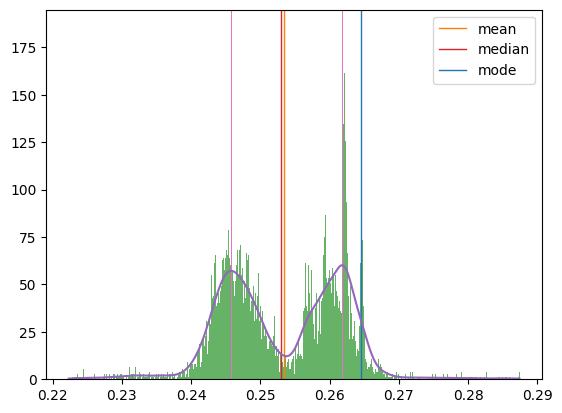

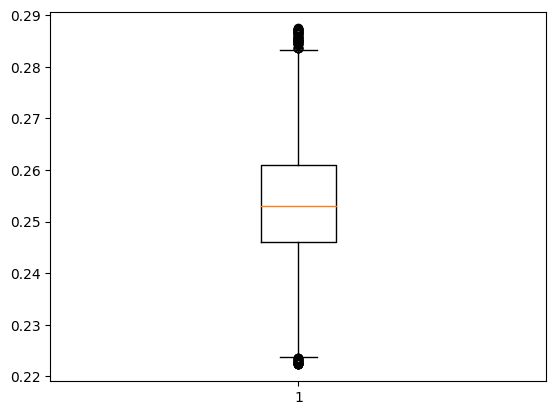

/home/wmnlab/D/database/2022-09-29/_Bandlock_Udp/sm07/#01
Length of list: 27570
Length of resulting list: 24660
[1.4679022480513393,1.4853136079806337]
[376, 600]
[1.4699939349750142, 1.483648970320418]
0.008705679964647257


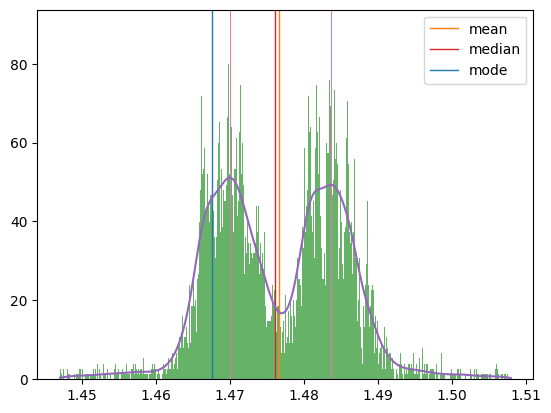

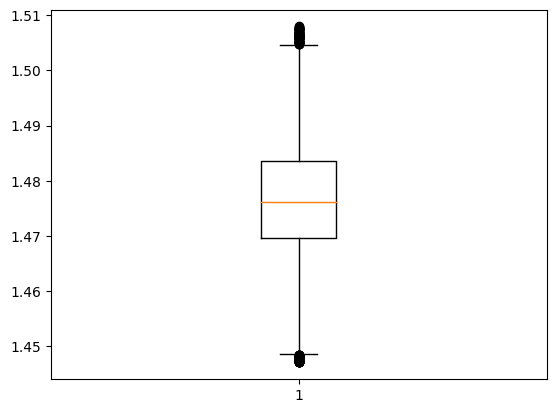

/home/wmnlab/D/database/2022-09-29/_Bandlock_Udp/sm08/#01
Length of list: 27393
Length of resulting list: 24844
[1.218703905740125,1.2392643254658837]
[197, 383, 524, 643, 884, 959]
[1.2085792825028703, 1.2221377282529264, 1.2324159048699044, 1.2410903943551552, 1.258658057934529, 1.2641251731563259]
0.010280209862879346


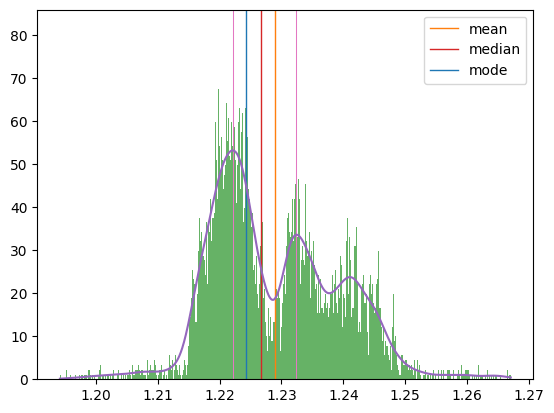

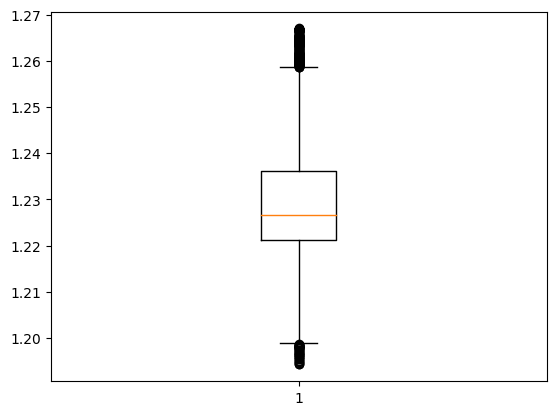

In [9]:
for _exp, (_times, _rounds) in Exp_Name.items():
    ### Check if these directories exist
    exp_path = os.path.join(db_path, _exp)
    print(exp_path)
    exp_dirs = []
    for i, dev in enumerate(devices):
        if _rounds:
            exp_dirs.append([os.path.join(exp_path, dev, _round) for _round in _rounds])
        else:
            _rounds = sorted(os.listdir(os.path.join(exp_path, dev)))
            exp_dirs.append([os.path.join(exp_path, dev, item) for item in _rounds])
        exp_dirs[i] = [item for item in exp_dirs[i] if os.path.isdir(item)]
        print(_times)
        pprint(exp_dirs[i])
        if len(exp_dirs[i]) != _times:
            print("************************************************************************************************")
            print("Warning: the number of directories does not match your specific number of experiment times.")
            print("************************************************************************************************")
            print()
            sys.exit()
    print()

    print(_exp)
    for j in range(_times):
        for i, dev in enumerate(devices):
            print(exp_dirs[i][j])
            dirpath = os.path.join(exp_dirs[i][j], "analysis")
            
            t1 = TicToc()  # create instance of class
            t1.tic()  # Start timer
            txdl_df = pd.read_csv(os.path.join(dirpath, "srv_dwnlnk_udp_packet_brief.csv"))
            rxdl_df = pd.read_csv(os.path.join(dirpath, "clt_dwnlnk_udp_packet_brief.csv"))
            txul_df = pd.read_csv(os.path.join(dirpath, "clt_uplnk_udp_packet_brief.csv"))
            rxul_df = pd.read_csv(os.path.join(dirpath, "srv_uplnk_udp_packet_brief.csv"))
            txdl_df['Timestamp'] = pd.to_datetime(txdl_df['Timestamp'])  # transmitted time from server
            rxdl_df['Timestamp'] = pd.to_datetime(rxdl_df['Timestamp'])  # arrival time to client
            txul_df['Timestamp'] = pd.to_datetime(txul_df['Timestamp'])  # transmitted time from client
            rxul_df['Timestamp'] = pd.to_datetime(rxul_df['Timestamp'])  # arrival time to server
            txdl_df['payload.time'] = pd.to_datetime(txdl_df['payload.time'])
            rxdl_df['payload.time'] = pd.to_datetime(rxdl_df['payload.time'])
            txul_df['payload.time'] = pd.to_datetime(txul_df['payload.time'])
            rxul_df['payload.time'] = pd.to_datetime(rxul_df['payload.time'])
            
            timedeltas, epoch_deltas = calc_delta(txdl_df, rxdl_df, txul_df, rxul_df)

            # n, bins, patches = plt.hist(epoch_deltas, 1000, density=False, facecolor='g', alpha=0.75)
            # plt.grid(True)
            # plt.show()

            # plt.boxplot(epoch_deltas)
            # plt.show()

            epoch_deltas, ret_list = del_outliers(epoch_deltas)
            timedeltas = [timedeltas[i] for i in ret_list]
            # timedeltas = list(map(lambda i: timedeltas[i], ret_list))
            kde = stats.gaussian_kde(epoch_deltas)
            xx = np.linspace(min(epoch_deltas), max(epoch_deltas), 1000)
            yy = kde(xx)

            stdev_1 = P.closed(mean(epoch_deltas) - stdev(epoch_deltas), mean(epoch_deltas) + stdev(epoch_deltas))
            # stdev_2 = P.closed(t_mean(timedeltas) - t_stdev(timedeltas), t_mean(timedeltas) + t_stdev(timedeltas))
            print(stdev_1)
            # print(stdev_2)
            max_index = list(signal.argrelextrema(yy, np.greater)[0])
            print(max_index)
            print([xx[i] for i in max_index])
            print(stdev(epoch_deltas))
            benchmarks = [xx[i] for i in max_index if xx[i] in stdev_1]
            n, bins, patches = plt.hist(epoch_deltas, 2000, density=True, facecolor='g', alpha=0.6)
            plt.axvline(mean(epoch_deltas), c='tab:orange', label='mean', linewidth=1)
            plt.axvline(median(epoch_deltas), c='tab:red', label='median', linewidth=1)
            plt.axvline(mode(epoch_deltas), c='tab:blue', label='mode', linewidth=1)
            # [plt.axvline(xx[i], c='tab:pink', linewidth=0.75) for i in max_index]
            [plt.axvline(item, c='tab:pink', linewidth=0.75) for item in benchmarks]
            # plt.axvline(mean(epoch_deltas) + stdev(epoch_deltas), c='tab:pink', linewidth=0.75)
            # plt.axvline(mean(epoch_deltas) - stdev(epoch_deltas), c='tab:pink', linewidth=0.75)
            plt.plot(xx, yy, c='tab:purple', linewidth=1.5)
            # plt.grid(True)
            plt.legend()
            plt.show()

            plt.boxplot(epoch_deltas)
            plt.show()